In [1]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=69aa12c066583ea91bc3772b5ad4cc61fea1ed01ad98a4545f8b1b31766825a5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import zipfile
import math
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import shutil
from efficientnet_pytorch import EfficientNet

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

In [3]:
print(torch.__version__)

1.11.0+cu113


In [4]:
device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
from google.colab import drive
drive.mount ('/content/gdrive')
!unzip "/content/gdrive/MyDrive/Dataset/Augmented_1.zip" -d "/content/labeled-images"
!unzip "/content/gdrive/MyDrive/Dataset/Augmented_2.zip" -d "/content/labeled-images"
!unzip "/content/gdrive/MyDrive/Dataset/Augmented_3.zip" -d "/content/labeled-images"

Streaming output truncated to the last 5000 lines.
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_5115559.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_5116039.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_5194025.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_53400.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_5423794.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_5451332.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_5500410.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_5511542.png  
  inflating: /content/labeled-images/Augmented_3/ulcerative-colitis-grade-1-2_augment/aug_3_566745.png 

In [6]:
!mkdir /content/dataset

In [7]:
cn1_path = "/content/labeled-images/Augmented_1/"
cn2_path = "/content/labeled-images/Augmented_2/"
cn3_path = "/content/labeled-images/Augmented_3/"
cn1 = ['barretts', 'barretts-short-segment', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a'] 
cn2 = ['esophagitis-b-d', 'hemorrhoids', 'ileum', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach']
cn3 = ['ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-2', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-3', 'z-line']

for name in cn1:
  path = str(cn1_path + name + '_augment')
  shutil.move (path, "/content/dataset" )

for name in cn2:
  path = str(cn2_path + name + '_augment')
  shutil.move (path, "/content/dataset" )

for name in cn3:
  path = str(cn3_path + name + '_augment')
  shutil.move (path, "/content/dataset" )

In [8]:
!rm -rf '/content/dataset/barretts-short-segment_augment/aug_0_2328103.png'
!rm -rf '/content/dataset/barretts_augment/aug_0_211206.png'
!rm -rf '/content/dataset/bbps-0-1_augment/aug_0_3938020.png'

In [9]:
#HYPERPARAMETERS

batch_size = 16
num_epochs = 5
num_classes = 23
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

In [10]:
transformer=transforms.Compose([
    #transforms.Resize((256,256)),
    transforms.Resize((50,50)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
])

In [11]:
dataset_path = '/content/dataset'

def load_dataset():
    train_dataset_manual = torchvision.datasets.ImageFolder(dataset_path, transform=transformer)
    train_loader_manual = torch.utils.data.DataLoader(train_dataset_manual)
    return train_loader_manual


full_dataset = load_dataset()


train_size = int(0.6 * len(full_dataset))
test_size = int (0.2 * len(full_dataset))
valid_size = len(full_dataset) - train_size - test_size


train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(full_dataset.dataset, [train_size, test_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

print('Full Dataset - ' + str(len(full_dataset)) + ' images.')
print('Train Set- ' + str(train_size) + ' images in ' + str(len(train_loader)) +' batches')
print('Testing Set - ' + str(test_size) + ' images in ' + str(len(test_loader)) + ' batches' )
print('Validation Set - ' + str(valid_size) + ' images in ' + str(len(valid_loader)) + ' batches')

train_count = train_size
test_count = test_size
valid_count = valid_size

Full Dataset - 25440 images.
Train Set- 15264 images in 954 batches
Testing Set - 5088 images in 318 batches
Validation Set - 5088 images in 318 batches


In [12]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([16, 3, 50, 50])
Image label dimensions: torch.Size([16])


In [13]:
root = pathlib.Path (dataset_path)
classes = sorted ([j.name.split('/')[-1] for j in root.iterdir()])
print (classes)
print(len(classes))

['barretts-short-segment_augment', 'barretts_augment', 'bbps-0-1_augment', 'bbps-2-3_augment', 'cecum_augment', 'dyed-lifted-polyps_augment', 'dyed-resection-margins_augment', 'esophagitis-a_augment', 'esophagitis-b-d_augment', 'hemorrhoids_augment', 'ileum_augment', 'impacted-stool_augment', 'polyps_augment', 'pylorus_augment', 'retroflex-rectum_augment', 'retroflex-stomach_augment', 'ulcerative-colitis-grade-0-1_augment', 'ulcerative-colitis-grade-1-2_augment', 'ulcerative-colitis-grade-1_augment', 'ulcerative-colitis-grade-2-3_augment', 'ulcerative-colitis-grade-2_augment', 'ulcerative-colitis-grade-3_augment', 'z-line_augment']
23


In [14]:
class ASPP(nn.Module):
	def __init__(self, dim_in, dim_out, rate=1, bn_mom=0.1):
		super(ASPP, self).__init__()
		self.branch1 = nn.Sequential(
			nn.Conv2d(dim_in, dim_out, 1, 1, padding=0, dilation=rate, bias=True),
			nn.BatchNorm2d(dim_out),
			nn.ReLU(inplace=True),
		)
		self.branch2 = nn.Sequential(
			nn.Conv2d(dim_in, dim_out, 3, 1, padding=6 * rate, dilation=6 * rate, bias=True),
			nn.BatchNorm2d(dim_out),
			nn.ReLU(inplace=True),
		)
		self.branch3 = nn.Sequential(
			nn.Conv2d(dim_in, dim_out, 3, 1, padding=12 * rate, dilation=12 * rate, bias=True),
			nn.BatchNorm2d(dim_out),
			nn.ReLU(inplace=True),
		)
		self.branch4 = nn.Sequential(
			nn.Conv2d(dim_in, dim_out, 3, 1, padding=18 * rate, dilation=18 * rate, bias=True),
			nn.BatchNorm2d(dim_out),
			nn.ReLU(inplace=True),
		)
		self.branch5_conv = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=True)
		self.branch5_bn = nn.BatchNorm2d(dim_out)
		self.branch5_relu = nn.ReLU(inplace=True)
		self.conv_cat = nn.Sequential(
			nn.Conv2d(dim_out * 5, dim_out, 1, 1, padding=0, bias=True),
			nn.BatchNorm2d(dim_out),
			nn.ReLU(inplace=True),
		)

	def forward(self, x):
		[b, c, row, col] = x.size()
		conv1x1 = self.branch1(x)
		conv3x3_1 = self.branch2(x)
		conv3x3_2 = self.branch3(x)
		conv3x3_3 = self.branch4(x)
		global_feature = torch.mean(x, 2, True)
		global_feature = torch.mean(global_feature, 3, True)
		global_feature = self.branch5_conv(global_feature)
		global_feature = self.branch5_bn(global_feature)
		global_feature = self.branch5_relu(global_feature)
		global_feature = F.interpolate(global_feature, (row, col), None, 'bilinear', True)

		feature_cat = torch.cat([conv1x1, conv3x3_1, conv3x3_2, conv3x3_3, global_feature], dim=1)
		result = self.conv_cat(feature_cat)
        
		return result

In [15]:
class FireModule (nn.Module):

    def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes):
        super(FireModule, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

In [16]:
class CustomBack (nn.Module):

    def __init__(self, os):
        super(CustomBack, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, kernel_size=7, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        
        self.fb1 = FireModule(96, 16, 64, 64)

        self.fb2 = FireModule(128, 16, 64, 64)

        rate = 16//os

        self.layers = []



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------

    def forward(self, input):
        self.layers = []
        x = self.conv1(input)
        x = self.relu(x)
        x = self.mp1(x)

        self.layers.append(x)
        
        x = self.fb1(x)
        self.layers.append(x)

        x = self.fb2(x)
        self.layers.append(x)

        return x

    def get_layers(self):
        return self.layers

In [17]:
class Gumbel(nn.Module):
    ''' 
    Returns differentiable discrete outputs. Applies a Gumbel-Softmax trick on every element of x. 
    '''
    def __init__(self):
        super(Gumbel, self).__init__()
        self.factor = 1.0
        self.gumbel_noise = True

    def forward(self, x):
        if not self.training:  # no Gumbel noise during inference
            return (x >= 0).float()

        if self.gumbel_noise:
            U = torch.rand_like(x)
            g= -torch.log( - torch.log(U + 1e-8) + 1e-8)
            x = x + g

        soft = torch.sigmoid(x / self.factor)
        hard = ((soft >= 0.5).float() - soft).detach() + soft
        assert not torch.any(torch.isnan(hard))
        
        return hard

class Binary_Gate_Unit(nn.Module):
    
    def __init__(self, in_channels = 1024,  k = 100):
        super(Binary_Gate_Unit, self).__init__()
        self.in_channels = in_channels
        self.k = k
        self.conv= nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias = False),
            nn.ReLU(inplace=True)            
            )
        self.fc1 = nn.Linear(k, int(torch.ceil(torch.tensor(k/2))))
        self.fc2 = nn.Linear(int(torch.ceil(torch.tensor(k/2))), k)
        
        self.gumbel = Gumbel()

    def forward(self,topk_prototypes):
        
        b = topk_prototypes.size(0)
        proto_weights = self.conv(topk_prototypes) # meta learner
        proto_weights = proto_weights.view(b, -1)
        proto_weights = self.fc1(torch.relu(proto_weights)) 
        proto_weights = self.fc2(proto_weights) # b, k
        proto_weights = self.gumbel(proto_weights)      
        proto_weights = proto_weights.view(b, 1, self.k, 1)
        
        return proto_weights


class Lesion_Location_Mining(nn.Module):

    def __init__(self, in_channels = 1024,  k = 100):
        super(Lesion_Location_Mining, self).__init__()
        self.k = k       
        self.BGU_fore =Binary_Gate_Unit(in_channels = in_channels,  k = k)
        self.BGU_back =Binary_Gate_Unit(in_channels = in_channels,  k = k)
        
    def forward(self, feats, soft_mask):
        
        b,c,h,w = feats.size()
        hard_mask = torch.max(soft_mask, dim = 1, keepdim = True)[1] # b, 1, h, w
        background_hard_mask = (hard_mask == 0).float()          
        foreground_hard_mask = (hard_mask == 1).float()
        assert torch.sum(hard_mask == 2) == 0, 'Error in Lesion_Location_Mining_Module'
        background_soft_mask, foreground_soft_mask = soft_mask.split(1, dim = 1)    #b, 1, h, w
        foreground_feats = feats * foreground_hard_mask # b, c, h, w
        background_feats = feats * background_hard_mask # b, c, h, w    
        feats = feats.view(b, c, -1) # b, c, hw        
        
        #****** foreground-->background **********#
        #key generator
        foreground_soft_mask = foreground_soft_mask.view(b, 1, -1)
        topk_idx = torch.topk(foreground_soft_mask, self.k, dim = -1, largest=True)[1]     
        topk_prototypes = []
        for i in range(b):
            feats_temp = feats[i,:,topk_idx[i]] # c, k
            topk_prototypes.append(feats_temp)
        topk_prototypes = torch.stack(topk_prototypes) # b, c, k
        topk_prototypes = topk_prototypes.view(b, c, self.k, 1)                
        proto_weights = self.BGU_fore(topk_prototypes) 
        topk_prototypes = topk_prototypes * proto_weights # b, c, k, 1         
               
        # b, c, h, w # b, c, k ---> 
        background_feats = background_feats.view(b, c, -1) # b, c, hw
        topk_prototypes = topk_prototypes.view(b, c, -1).permute(0, 2, 1) # b, k, c 
        fore_attention_map = torch.matmul(topk_prototypes, background_feats) # b, k ,hw
       
        #norm + relu
        norm_prototypes = torch.norm(topk_prototypes, dim = -1, keepdim=True) # b, k, 1
        norm_background_feats = torch.norm(background_feats, dim = 1, keepdim=True) #b, 1, hw
        norm = torch.bmm(norm_prototypes, norm_background_feats) # b, k, hw
        fore_attention_map =  fore_attention_map /(norm + 1e-8)
        fore_attention_map = torch.relu(fore_attention_map)
        fore_attention_map = fore_attention_map.view(b, self.k, h, w) 
        fore_attention_map = torch.max(fore_attention_map, dim = 1,  keepdim = True) [0]

        #****** background-->foreground**********#
        #key generator
        background_soft_mask = background_soft_mask.view(b, 1, -1)
        topk_idx = torch.topk(background_soft_mask, self.k, dim = -1, largest=True)[1]                 
        topk_prototypes = []
        for i in range(b):
            feats_temp = feats[i,:,topk_idx[i]] # c, k
            topk_prototypes.append(feats_temp)
        topk_prototypes = torch.stack(topk_prototypes) # b, c, k
        topk_prototypes = topk_prototypes.view(b, c, self.k, 1)        
        proto_weights = self.BGU_back(topk_prototypes) 
        topk_prototypes = topk_prototypes * proto_weights # b, c, k, 1
               
        # b, c, h, w # b, c, k ---> 
        foreground_feats = foreground_feats.view(b, c, -1) # b, c, hw
        topk_prototypes = topk_prototypes.view(b, c, -1).permute(0, 2, 1) # b, k, c
        back_attention_map = torch.matmul(topk_prototypes, foreground_feats) # b, k ,hw
        #norm + relu
        norm_prototypes = torch.norm(topk_prototypes, dim = -1, keepdim=True) # b, k, 1
        norm_foreground_feats = torch.norm(foreground_feats, dim = 1, keepdim=True) #b, 1, hw
        norm = torch.bmm(norm_prototypes, norm_foreground_feats) # b, k, hw
        back_attention_map =  back_attention_map /(norm + 1e-8)
        back_attention_map = torch.relu(back_attention_map)
        back_attention_map = back_attention_map.view(b, self.k, h, w) 
        back_attention_map = torch.max(back_attention_map, dim = 1,  keepdim = True) [0]
     
        #merging
        feats = feats.view(b, c, h, w)
        foreground_soft_mask = foreground_soft_mask.view(b, 1, h, w)
        feats = feats + feats * (foreground_soft_mask - back_attention_map + fore_attention_map)
        
        return feats  #b, c, h,w    


In [18]:
"""
Applies the mish function element-wise:
mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + exp(x)))
"""
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        if torch.__version__ >= "1.9":
            return F.mish(input)
        else:
            return mish(input)

def mish(input):
    return input * torch.tanh(F.softplus(input))

In [19]:
class GI_Model(nn.Module):
    def __init__(self, K=100):
        super(GI_Model, self).__init__()
        self.backbone = None
        self.backbone_layers = None
        self.dropout = nn.Dropout(0.5)
        #self.upsample_sub_x2 = nn.UpsamplingBilinear2d(scale_factor=2) 
        #self.upsample_sub_x4 = nn.UpsamplingBilinear2d(scale_factor=4)         
        #self.shortcut_conv = nn.Sequential(nn.Conv2d(128, 48, 1, 1, padding=1//2, bias=True),
        self.shortcut_conv = nn.Sequential(nn.Conv2d(96, 48, 1, 1, padding=1//2, bias=True),
				nn.BatchNorm2d(48),
				nn.ReLU(inplace=True),
		)
        self.aspp = ASPP(dim_in=128, dim_out=128, rate=16//16, bn_mom = 0.99)

        self.coarse_head = nn.Sequential(
				nn.Conv2d(128+48, 128, 3, 1, padding=1, bias=True),
        #nn.Conv2d(128, 128, 3, 1, padding=1, bias=True),
				nn.BatchNorm2d(128),
				nn.ReLU(inplace=True),
				nn.Dropout(0.5),
				nn.Conv2d(128, 128, 3, 1, padding=1, bias=True),
				nn.BatchNorm2d(128),
				nn.ReLU(inplace=True),
				nn.Dropout(0.1),
                nn.Conv2d(128, 2, kernel_size=1, stride=1, padding=0, bias=True)
		)

        self.cls_head = nn.Sequential (
          #nn.Conv2d(128, 256, kernel_size=3, stride=1),
          nn.Conv2d(128, 256, kernel_size=1, stride=1),
          nn.BatchNorm2d(256),
			    Mish(),
       
          #nn.Conv2d(256, 512, kernel_size=3, stride=1),
          nn.Conv2d(256, 512, kernel_size=1, stride=1),
          nn.BatchNorm2d(512),
			    Mish(),
       
          #nn.Conv2d(512, 1024, kernel_size=3, stride=1),
          nn.Conv2d(512, 1024, kernel_size=1, stride=1),
          nn.BatchNorm2d(1024),
			    Mish()
        
    )

        self.LLM = Lesion_Location_Mining(128, 10)       
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.avgpool5 = nn.AdaptiveAvgPool2d(5)

        self.cls_predict = nn.Linear(1024, num_classes, bias = False)       
                       
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.backbone = CustomBack(8)
        self.backbone_layers = self.backbone.get_layers()

        self.checker = nn.Conv2d(50, 128, kernel_size=3, stride=1)


    def forward(self, x):

      #CUSTOM BACKBONE LAYER
        x = self.backbone(x)
        
        
        layers = self.backbone.get_layers()                 #shllow feature
        feature_shallow = self.shortcut_conv(layers[0])    
        feature_aspp = self.aspp(layers[-1])            
        feature_coarse= self.dropout(feature_aspp)          #coarse seg   
        #feature_coarse = self.upsample_sub_x2(feature_coarse)

        #Added
        #print('feature coarse')
        #print(feature_coarse.shape)

        feature_coarse = self.avgpool5(feature_coarse)
        feature_shallow = self.avgpool5 (feature_shallow)

        #

        feature_coarse = torch.cat([feature_coarse,feature_shallow],1)
        seg_coarse = self.coarse_head(feature_coarse)              
        cls_feats = layers[-2]                              #####cls

        #Added
        #print('cls feats')
        #print(cls_feats.shape)

        cls_feats = self.avgpool5(cls_feats)

        #x = self.checker(cls_feats)
        # 

        b, c, h, w = cls_feats.size()
        mask_coarse = torch.softmax(seg_coarse, dim = 1)       
        mask_coarse = F.interpolate(mask_coarse, size=(h, w), mode="bilinear", align_corners=False)
        #CHANGE HERE
        
        cls_feats = self.LLM(feats = cls_feats, soft_mask =  mask_coarse)      
                
        
        cls_feats = self.cls_head(cls_feats)                     
        cls_out = self.avgpool(cls_feats)

        cls_out = cls_out.view(b, -1) 

        #print ('cls_out', cls_out.shape)
        cls_out = self.cls_predict(cls_out)     

        return cls_out
        

In [20]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB

        #self.modelA.cls_predict = nn.Identity()
        #self.modelB._fc = nn.Identity()

        #From S102
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.ad = nn.AlphaDropout(0.5)
        self.r = nn.ReLU(inplace = True)

        self.classifier = nn.Linear(in_features = 1023, out_features = num_classes)

        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        #x1 = x1.view(x1.size(0), -1)

        #print('x1_shape:',x1.shape)

        x2 = self.modelB(x)
        #x2 = x2.view(x2.size(0), -1)

        #print('x2_shape:',x2.shape)

        x = torch.cat((x1, x2), dim=1)

        #print('x_cat:',x.shape)

        #x = self.gap(x)

        #print('x_cat:',x.shape)

        x = self.ad(x)

        #print('x_cat:',x.shape)

        x = self.r(x)
        
        

        x = self.classifier(x)
        return x

In [21]:
PATHa = '/content/gdrive/MyDrive/Dataset/CustomModel_50epochs'
PATHb = '/content/gdrive/MyDrive/Dataset/EfficientNetBo_50_Epochs'

#Load Models
modelA = GI_Model().to(device) 
modelB = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [22]:
# Load state dicts
modelA.load_state_dict(torch.load(PATHa))

<All keys matched successfully>

In [23]:
modelB.load_state_dict(torch.load(PATHb))

<All keys matched successfully>

In [24]:
model_new = MyEnsemble(modelA, modelB).to(device)

In [25]:
state_dict = torch.load('/content/Ensemble_95Epoch')

FileNotFoundError: ignored

In [ ]:
model_new.load_state_dict(state_dict)

<All keys matched successfully>

In [26]:
optimizer=Adam(model_new.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
loss_function=nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model_new.train()

    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        #print (i)
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model_new(images)
        
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        #train_loss+= loss.cpu().data*images.size(0)
        train_loss += loss.item()
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model_new.eval()
    
    valid_accuracy = 0.0
    valid_loss = 0.0

    for i, (images,labels) in enumerate(valid_loader):
        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
            
        outputs=model_new(images)

        loss = loss_function (outputs, labels)
        _,prediction=torch.max(outputs.data,1)
        valid_accuracy += int(torch.sum(prediction == labels.data))
        #test_accuracy+=int(torch.sum(prediction==labels.data))
        valid_loss+= loss.item()
        
    #test_accuracy=test_accuracy/test_count
    valid_accuracy = valid_accuracy/test_count
    valid_loss = valid_loss/test_count
        
        
    print('Epoch: %d Train Loss: %.5f Train Accuracy: %.5f Validation Loss: %.5f  Validation Accuracy: %.5f' % (epoch, train_loss, train_accuracy, valid_loss, valid_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch: 0 Train Loss: 0.00456 Train Accuracy: 0.97497 Validation Loss: 0.00932  Validation Accuracy: 0.95460
Epoch: 1 Train Loss: 0.00455 Train Accuracy: 0.97478 Validation Loss: 0.01213  Validation Accuracy: 0.94261
Epoch: 2 Train Loss: 0.00444 Train Accuracy: 0.97556 Validation Loss: 0.01041  Validation Accuracy: 0.94969
Epoch: 3 Train Loss: 0.00444 Train Accuracy: 0.97838 Validation Loss: 0.01048  Validation Accuracy: 0.94772
Epoch: 4 Train Loss: 0.00393 Train Accuracy: 0.98035 Validation Loss: 0.01036  Validation Accuracy: 0.95067


In [ ]:
    torch.save(model_new.state_dict(),'/content/Ensemble_100Epoch')

In [27]:
path = '/content/gdrive/MyDrive/Dataset/Combined_100Epoch'
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
model_new.eval()

MyEnsemble(
  (modelA): GI_Model(
    (dropout): Dropout(p=0.5, inplace=False)
    (shortcut_conv): Sequential(
      (0): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (aspp): ASPP(
      (branch1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (branch3): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [29]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images, labels = images.to(device), labels.to(device)

In [31]:
y_pred = []
y_true = []

# iterate over test data
#for inputs, labels in test_loader:
for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)

    output = model_new(images) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1])
    output = output.data.cpu().numpy()

    y_pred.extend(output) # Save Prediction
        
    labels1 = labels.data.cpu().numpy()
    y_true.extend(labels1) # Save Truth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [32]:
print (len(y_pred))
print (len(y_true))
print(y_pred)
print(y_true)

5088
5088
[4, 7, 2, 21, 18, 4, 2, 8, 15, 2, 6, 19, 19, 19, 10, 9, 11, 14, 22, 17, 7, 17, 3, 0, 10, 8, 15, 6, 21, 1, 11, 12, 0, 5, 14, 22, 16, 18, 20, 3, 16, 4, 12, 9, 6, 15, 1, 13, 15, 4, 3, 15, 14, 18, 20, 9, 16, 20, 5, 18, 4, 7, 2, 17, 20, 17, 20, 20, 8, 21, 10, 18, 6, 1, 0, 1, 19, 15, 3, 1, 8, 0, 14, 3, 18, 12, 18, 18, 0, 12, 16, 0, 9, 19, 8, 19, 17, 4, 2, 8, 0, 15, 18, 20, 22, 5, 13, 17, 20, 19, 20, 16, 17, 2, 18, 9, 7, 17, 4, 9, 18, 22, 22, 4, 14, 13, 12, 16, 17, 22, 18, 17, 22, 11, 3, 17, 10, 0, 1, 20, 17, 6, 1, 17, 20, 9, 12, 19, 22, 15, 19, 16, 21, 21, 0, 1, 4, 10, 21, 18, 2, 15, 9, 3, 15, 10, 16, 2, 12, 11, 8, 15, 15, 19, 2, 11, 20, 14, 15, 22, 5, 5, 15, 18, 14, 19, 8, 19, 7, 18, 2, 18, 12, 11, 3, 12, 12, 6, 22, 21, 0, 3, 22, 16, 15, 18, 19, 7, 14, 21, 7, 16, 13, 20, 4, 11, 17, 7, 16, 12, 11, 14, 13, 19, 11, 19, 7, 15, 9, 20, 5, 21, 22, 10, 1, 8, 11, 7, 19, 17, 6, 2, 3, 2, 1, 17, 15, 2, 15, 17, 19, 20, 16, 7, 9, 2, 12, 14, 15, 18, 5, 18, 4, 8, 15, 0, 8, 6, 17, 3, 7, 20, 14, 11

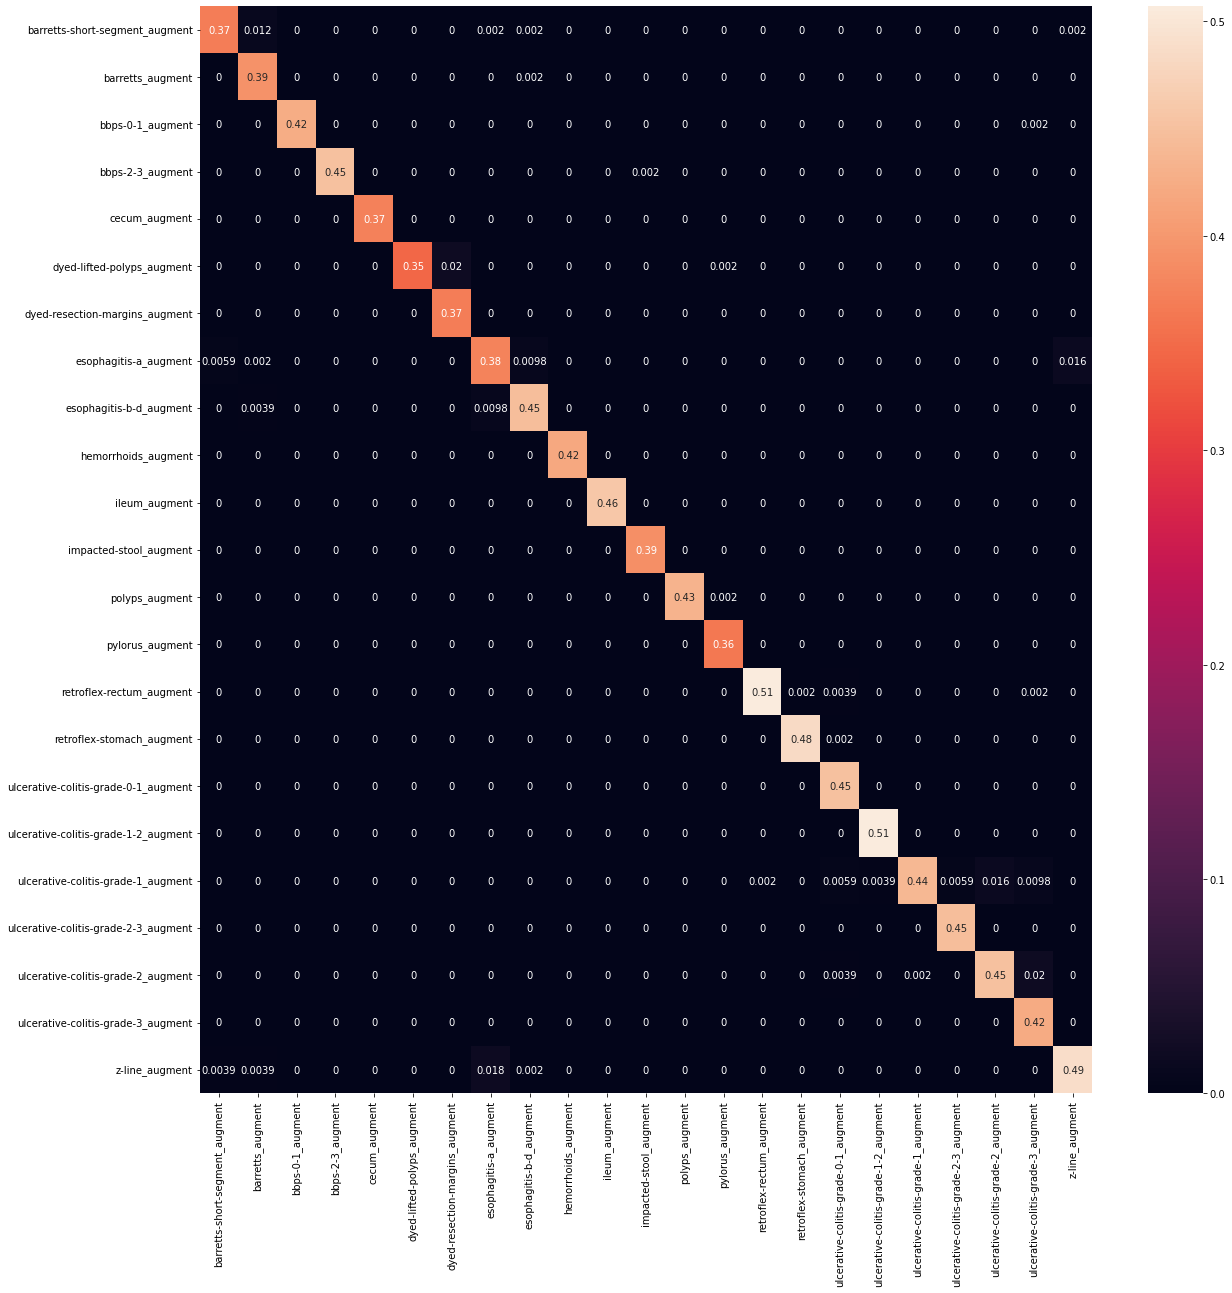

In [33]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [34]:
classification_report(y_true, y_pred,zero_division=0,output_dict=True)

{'0': {'f1-score': 0.964102564102564,
  'precision': 0.9740932642487047,
  'recall': 0.9543147208121827,
  'support': 197},
 '1': {'f1-score': 0.970873786407767,
  'precision': 0.9478672985781991,
  'recall': 0.9950248756218906,
  'support': 201},
 '10': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 233},
 '11': {'f1-score': 0.9974811083123425,
  'precision': 0.9949748743718593,
  'recall': 1.0,
  'support': 198},
 '12': {'f1-score': 0.9977324263038548,
  'precision': 1.0,
  'recall': 0.995475113122172,
  'support': 221},
 '13': {'f1-score': 0.9946236559139785,
  'precision': 0.9893048128342246,
  'recall': 1.0,
  'support': 185},
 '14': {'f1-score': 0.9904030710172744,
  'precision': 0.9961389961389961,
  'recall': 0.9847328244274809,
  'support': 262},
 '15': {'f1-score': 0.9959514170040485,
  'precision': 0.9959514170040485,
  'recall': 0.9959514170040485,
  'support': 247},
 '16': {'f1-score': 0.9828326180257511,
  'precision': 0.9662447257383966,
  'recall': 1.0,
 